In [1]:
import torch 
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
import numpy as np
import cv2
import matplotlib.pyplot as plt
import random
import PIL
from facenet_pytorch import MTCNN, InceptionResnetV1
import torch.nn.functional as F

In [2]:
mtcnn=MTCNN()
model=InceptionResnetV1(pretrained='vggface2').eval()

In [3]:
for i in model.parameters():
    i.requires_grad=False
    

In [4]:
for i in model.last_linear.parameters():
    i.requires_grad=True
for i in model.last_bn.parameters():
    i.requires_grad=True
for i in model.logits.parameters():
    i.requires_grad=True

In [5]:
for i in model.parameters():
#     i.requires_grad=True
    if(i.requires_grad):
        print("yes")

yes
yes
yes
yes
yes


In [6]:
print(model)

InceptionResnetV1(
  (conv2d_1a): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_2a): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_2b): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (maxpool_3a): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2d_3b): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_4a): 

In [7]:
device = torch.device("cuda") if torch.cuda.is_available() else "cpu"

In [8]:
net=model.to(device)

In [9]:

class SiameseNetworkDataset(Dataset):
    def __init__(self,imageFolderDataset,transform=None):
        super().__init__()
        self.imageFolderDataset = imageFolderDataset    
        self.transform = transform
        
    def __getitem__(self,index):
        img0_tuple = random.choice(self.imageFolderDataset.imgs)
        a=[]
        for x in range(5):
            should_get_same_class = random.randint(0,1) 
            if should_get_same_class:
                while True:

                    img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                    if img0_tuple[1] != img1_tuple[1]:
                        break
            else:

                while True:

                    img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                    if img0_tuple[1] == img1_tuple[1]:
                        break

            img0 = Image.open(img0_tuple[0])
            img1 = Image.open(img1_tuple[0])
            img0 = img0.convert("RGB")
            img1 = img1.convert("RGB")


            if self.transform is not None:
                img0 = self.transform(img0)
                img1 = self.transform(img1)
            
            if img1_tuple[1] != img0_tuple[1]:

                a.append((img0, img1, torch.from_numpy(np.array([1], dtype=np.float32))))
            else:
                a.append(( img0, img1, torch.from_numpy(np.array([0], dtype=np.float32))))
        return a
    def __len__(self):
        return len(self.imageFolderDataset.imgs)

In [10]:
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [11]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224,224)),
#     transforms.RandomHorizontalFlip(0.5),
# #     transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
#     transforms.RandomApply([transforms.ColorJitter(brightness=0.8, contrast=0.8),],0.4),
    
#     transforms.RandomAdjustSharpness(0.8, p=0.3),
    
])

In [12]:
data=torchvision.datasets.ImageFolder('/mnt/4tb/FaceRecog/celeb_dataset/cropped_data' ,transform=transform)

In [13]:
sdata=SiameseNetworkDataset(data,transform)

In [14]:
data_loader=DataLoader(sdata,64,shuffle=True)

torch.Size([3, 224, 224])
tensor([0.])


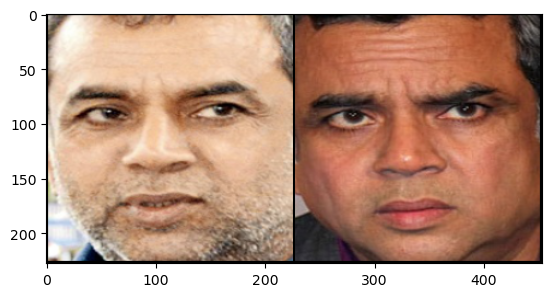

In [15]:
for x in data_loader:
    for i,j,l in x:
        plt.imshow(np.transpose(torchvision.utils.make_grid([i[0],j[0]], padding=2, normalize=True).cpu(),(1,2,0)))
        print(i[0].shape)
        print(l[0])
        break
    break

In [16]:
class ContrastiveLoss(torch.nn.Module):
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
       
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)

        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                    (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


        return loss_contrastive

In [17]:

criterion = ContrastiveLoss()
optimizer = torch.optim.Adam(net.parameters(), lr = 0.0001 )

In [18]:
counter = []
loss_history = [] 
iteration_number= 0

for epoch in range(10):


    for i, x in enumerate(data_loader):
        
        for (img0, img1, label) in x:

        
            img0, img1, label = img0.to(device), img1.to(device), label.to(device)


            optimizer.zero_grad()


            output1 = net(img0)
            output2=net(img1)


            loss_contrastive = criterion(output1, output2, label)


            loss_contrastive.backward()

    #         torch.nn.utils.clip_grad_norm_(net.parameters(), 5)
            optimizer.step()

        
        if i % 10 == 0 :
            print(f"Epoch number {epoch}\n Current loss {loss_contrastive.item()}\n")
            iteration_number += 10

            counter.append(iteration_number)
            loss_history.append(loss_contrastive.item())



Epoch number 0
 Current loss 0.7158527374267578

Epoch number 0
 Current loss 0.47658994793891907

Epoch number 0
 Current loss 0.5877625346183777

Epoch number 0
 Current loss 0.46360117197036743

Epoch number 0
 Current loss 0.531856119632721

Epoch number 0
 Current loss 0.49473148584365845

Epoch number 0
 Current loss 0.5248898267745972

Epoch number 0
 Current loss 0.5413881540298462

Epoch number 0
 Current loss 0.48170918226242065

Epoch number 0
 Current loss 0.6026754379272461

Epoch number 0
 Current loss 0.41968876123428345

Epoch number 0
 Current loss 0.553612232208252

Epoch number 0
 Current loss 0.3983932435512543

Epoch number 0
 Current loss 0.4200369119644165

Epoch number 0
 Current loss 0.43602144718170166

Epoch number 0
 Current loss 0.4340146780014038

Epoch number 0
 Current loss 0.41129422187805176

Epoch number 0
 Current loss 0.46467727422714233

Epoch number 0
 Current loss 0.3712802529335022

Epoch number 1
 Current loss 0.4561033844947815

Epoch number 1

Epoch number 8
 Current loss 0.4833294749259949

Epoch number 8
 Current loss 0.48001939058303833

Epoch number 8
 Current loss 0.5414003133773804

Epoch number 8
 Current loss 0.4631742835044861

Epoch number 9
 Current loss 0.4680546522140503

Epoch number 9
 Current loss 0.4133071303367615

Epoch number 9
 Current loss 0.5055839419364929

Epoch number 9
 Current loss 0.45039933919906616

Epoch number 9
 Current loss 0.4307808578014374

Epoch number 9
 Current loss 0.42647093534469604

Epoch number 9
 Current loss 0.4030260145664215

Epoch number 9
 Current loss 0.36294010281562805

Epoch number 9
 Current loss 0.47673141956329346

Epoch number 9
 Current loss 0.3776441216468811

Epoch number 9
 Current loss 0.5472900867462158

Epoch number 9
 Current loss 0.4622398316860199

Epoch number 9
 Current loss 0.4534153938293457

Epoch number 9
 Current loss 0.40858355164527893

Epoch number 9
 Current loss 0.41488972306251526

Epoch number 9
 Current loss 0.4414272904396057

Epoch number 

In [19]:
torch.save(net,"flayer_model.pt")